In [30]:
pip install PyPDF2 py-readability-metrics wordcloud nltk 


Note: you may need to restart the kernel to use updated packages.


In [8]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from PyPDF2 import PdfReader
from readability import Readability
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to /Users/krm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/krm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/krm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# 3. Characterization and Objectivity
The issue at hand is the controversy surrounding Harvard University President Claudine Gay, specifically mounting allegations of plagiarism in her academic work.

| **Source** | **Characterization of the Issue** | **Impressions on Objectivity** |
| :--- | :--- | :--- |
| **Reuters** | Focuses on the **institutional response and resolution**: President Gay is submitting corrections to her dissertation after the university found "inadequate citation" but not "research misconduct." The article reports on procedural steps. | Appears **procedural and relatively objective**. The article primarily reports statements from a university spokesperson and the Harvard Corporation. It presents the university's investigation findings as the central fact. |
| **Fox News** | Focuses on the **escalation and severity** of the claims: a new complaint outlining "over 40 allegations of plagiarism" was received. It emphasizes that this is a "pattern of misconduct" and gives a large platform to **critics** who challenge the university's response. | Appears **critical and advocacy-driven**. It uses strong, emotive language in the headline ("Embattled," "hit with more plagiarism charges") and frames the story around the continued pressure on the university's governing body. |

# 4.a PyPDF2 Text Extraction and Anomalies
This section uses PyPDF2 to extract and clean the text from the documents.

In [38]:
# --- File Paths 
FOX_NEWS_FILE = '/Users/krm/OIM_7502_classwork/data/foxnews.com-Embattled Harvard University President Claudine Gay hit with more plagiarism charges.pdf'
REUTERS_FILE = '/Users/krm/OIM_7502_classwork/data/reuters.com-Harvard president will submit dissertation edits after plagiarism allegations.pdf'

def extract_and_clean_text(pdf_path):
    """Extracts text from PDF and performs cleaning to remove common noise."""
    text = ""
    try:
        with open(pdf_path, 'rb') as file:
            reader = PdfReader(file)
            for page in reader.pages:
                text += page.extract_text() or ""
    except Exception as e:
        print(f"Error reading {pdf_path}. Ensure the file path is correct: {e}")
        return ""

    
    text = re.sub(r'http[s]?://[^\s]+|Page \d+/\d+|\d+/\d+|(?:Acquire Licensing Rights|Advertisement Scroll to continue|Our Standards: The Thomson Reuters Trust Principles|More From Fox News|Brian Flood is a media editor/reporter for FOX News Digital|Get all the stories you need-to-know from the most powerful name in news delivered first thing every morning to your inbox|Subscribe Promoted).*?', ' ', text, flags=re.DOTALL)
    text = re.sub(r'By Brian Flood Fox News|Reporting by Gabriella Borter; editing by Donna Bryson and Jonathan Oatis.*|Fox News\' David Rutz contributed.*|2023-24 NFL playoff odds.*|SCOTUS PUBLIC VIEWING TO HONOR JUSTICE O CONNOR.*|Video|Gabriella Borter is a reporter on the U.S. National Affairs team.*', ' ', text, flags=re.DOTALL)
    text = re.sub(r'\(Haiyun Jiang/Bloomberg via Getty Images\)|REUTERS/Ken Cedeno/File Photo|Purel Life|51st', ' ', text)
    
    # Collapse multiple newlines/spaces and strip
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


fox_text = extract_and_clean_text(FOX_NEWS_FILE)
reuters_text = extract_and_clean_text(REUTERS_FILE)

print("--- Extracted and Cleaned Fox News Text ---")
print(fox_text)
print("\n" + "="*50 + "\n")
print("--- Extracted and Cleaned Reuters Text ---")
print(reuters_text)

--- Extracted and Cleaned Fox News Text ---
1 / 5Brian FloodEmbattled Harvard University President Claudine Gay hit with more plagiarism charges foxnews.com /media/embattled-harvard-university-president-claudine-gay-hit-more-plagiarism-charges Media Harvard ‘received a complaint outlining over 40 allegations of plagiarism,’ according to the Free Beacon By Brian Flood Fox News Published December 20, 2023 12:59pm EST Harvard president facing 40 new allegations of plagiarism Fox News' Molly Line reports the latest on the allegations. Embattled Harvard University President Claudine Gay has been slapped with additional charges of plagiarism. The Washington Free Beacon reported Harvard "received a complaint outlining over 40 allegations of plagiarism" against Gay on T uesday , noting a letter was sent to Harvard's research integrity of ficer, Stacey Springs, outlining the claims. "The document paints a picture of a pattern of misconduct more extensive than has been previously reported and pu

# 4.b. Observed Anomalies in the Extracted Text

Even after basic text cleaning, several issues remain:

Fragmented Sentences: In the Fox News article, certain lines like those containing the word “without” appear disconnected or oddly placed, suggesting issues caused by PDF formatting during extraction.

Off-topic Inserts: Some portions, especially in the Fox article, include unrelated content such as NAACP commentary or sports headlines. These seem to come from sidebars or footers and aren't relevant to the core news story.

Extra Metadata: Elements like photo credits, author emails, and copyright messages are embedded in the text and introduce unnecessary noise that may affect analysis.

# 5.a Full Article Sentiment Analysis (NLTK VADER)

In [40]:
# Initialize the VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores for the full cleaned texts
fox_sentiment = sia.polarity_scores(fox_text)
reuters_sentiment = sia.polarity_scores(reuters_text)

print("Fox News Sentiment:", fox_sentiment)
print("Reuters Sentiment:", reuters_sentiment)

# Create a DataFrame for comparison
sentiment_data = {
    'Source': ['Fox News', 'Reuters'],
    'Neg': [fox_sentiment['neg'], reuters_sentiment['neg']],
    'Neu': [fox_sentiment['neu'], reuters_sentiment['neu']],
    'Pos': [fox_sentiment['pos'], reuters_sentiment['pos']],
    'Compound': [fox_sentiment['compound'], reuters_sentiment['compound']]
}
sentiment_df = pd.DataFrame(sentiment_data)
print("\n--- 5.a. Comparison of Full Article Sentiment Scores ---")
print(sentiment_df)


Fox News Sentiment: {'neg': 0.066, 'neu': 0.864, 'pos': 0.071, 'compound': 0.7243}
Reuters Sentiment: {'neg': 0.07, 'neu': 0.915, 'pos': 0.015, 'compound': -0.9655}

--- 5.a. Comparison of Full Article Sentiment Scores ---
     Source    Neg    Neu    Pos  Compound
0  Fox News  0.066  0.864  0.071    0.7243
1   Reuters  0.070  0.915  0.015   -0.9655


# 5.b. Sentiment vs. Personal Reading

Interpretation:
There is a clear contrast between the two articles’ sentiment scores. Reuters displays a strong negative sentiment (Compound: -0.9655), which fits its coverage of sensitive topics like “plagiarism,” “allegations,” and calls for resignation. In contrast, the Fox News piece appears strongly positive (Compound: 0.7243), which is unexpected given the subject matter.

This positive tone may be due to a high neutral value (0.864) and the inclusion of favorable language such as public backing from the Harvard Board, defense from the NAACP, and quotes VADER tends to interpret as positive. The Fox article’s very low negative score (0.066) suggests that most of the harsh or critical language was either minimized during text cleaning or outweighed by optimistic statements.

# 6.  Headline Sentiment Analysis

In [43]:
fox_headline = "Embattled Harvard University President Claudine Gay hit with more plagiarism charges"
reuters_headline = "Harvard president will submit dissertation edits after plagiarism allegations"

fox_h_sentiment = sia.polarity_scores(fox_headline)
reuters_h_sentiment = sia.polarity_scores(reuters_headline)

headline_data = {
    'Source': ['Fox News Headline', 'Reuters Headline'],
    'Neg': [fox_h_sentiment['neg'], reuters_h_sentiment['neg']],
    'Neu': [fox_h_sentiment['neu'], reuters_h_sentiment['neu']],
    'Pos': [fox_h_sentiment['pos'], reuters_h_sentiment['pos']],
    'Compound': [fox_h_sentiment['compound'], reuters_h_sentiment['compound']]
}
headline_df = pd.DataFrame(headline_data)
print("--- 6.a. Headline Sentiment Comparison ---")
print(headline_df)

--- 6.a. Headline Sentiment Comparison ---
              Source    Neg    Neu  Pos  Compound
0  Fox News Headline  0.192  0.808  0.0   -0.3353
1   Reuters Headline  0.000  1.000  0.0    0.0000


# 6.a Headline Sentiment Interpretation

Both headlines lean toward negativity, aligning to some degree with the overall article tone. However, the Fox News headline (Compound score: -0.3353) carries a stronger negative sentiment than the Reuters headline (Compound: 0.0000). This is due to Fox’s use of emotionally charged terms like “Embattled,” “hit,” and “plagiarism charges.”

In contrast, Reuters uses more neutral phrasing like “edits” and “allegations,” which VADER interprets as procedural rather than emotional, resulting in a neutral sentiment score. This difference helps highlight the tonal contrast found in the full article analyses.
Do These Headline Scores Match the Full Article Sentiment?

Fox News:
The headline shows a negative score (-0.3353), which does not align with the article's overall positive tone (Compound: 0.7243). This mismatch may be due to the body of the article focusing on defensive or supportive statements — such as endorsements from leadership — which dilute the negativity introduced in the headline.

Reuters:
While the Reuters headline scores as neutral (0.0000), the full article leans strongly negative (Compound: -0.9655). This suggests that despite the headline’s procedural wording, the article itself contains heavily negative terms like “plagiarism,” “pressure to resign,” and “investigation,” which VADER detects more clearly in the body than the title.




# 7 Readability Scores (py-readability-metrics)

In [47]:
# Calculate readability scores
fox_readability = Readability(fox_text)
reuters_readability = Readability(reuters_text)

# We will use 3 scores: Flesch-Kincaid Grade Level, Dale-Chall Score, and Gunning Fog Index
readability_data = {
    'Source': ['Fox News', 'Reuters'],
    'Flesch-Kincaid Grade Level': [fox_readability.flesch_kincaid().score, reuters_readability.flesch_kincaid().score],
    'Dale-Chall Readability Score': [fox_readability.dale_chall().score, reuters_readability.dale_chall().score],
    'Gunning Fog Index': [fox_readability.gunning_fog().score, reuters_readability.gunning_fog().score]
}
readability_df = pd.DataFrame(readability_data)
print("\n--- 7.b. Comparison of Readability Scores ---")
print(readability_df)



--- 7.b. Comparison of Readability Scores ---
     Source  Flesch-Kincaid Grade Level  Dale-Chall Readability Score  \
0  Fox News                   19.008636                     12.789485   
1   Reuters                   20.837154                     13.027845   

   Gunning Fog Index  
0          21.625358  
1          21.824307  


# 7.a. Explanation of Selected Readability Metrics

Flesch-Kincaid Grade Level:
This score estimates the U.S. school grade level needed to comprehend the text. It’s calculated using the average sentence length and syllables per word. A lower score indicates the content is easier to read and understand.

Dale-Chall Readability Score:
This measure evaluates how difficult a passage is based on the average sentence length and how many uncommon words it contains (i.e., not on a familiar-word list). Scores above 9.0 generally imply the material is challenging, often at a college level.

Gunning Fog Index:
This index estimates how many years of education a reader would typically need to grasp the text. It takes into account the use of long, complex words (3+ syllables) and overall sentence length. A score over 12 usually means the content may be too advanced for general readers.

# 7.b. Comparison of Readability Scores

An analysis of the readability results shows that both articles are quite complex, with difficulty levels exceeding what is considered accessible to the general public — indicating post-graduate reading complexity.

Using the measured scores (Fox News: Flesch-Kincaid 19.01, Dale-Chall 12.79, Gunning Fog 21.63; Reuters: Flesch-Kincaid 20.84, Dale-Chall 13.03, Gunning Fog 21.82):

The Reuters article is harder to read across all metrics compared to Fox News. This may be due to slightly more complex sentence structure and vocabulary, even though its tone appears more neutral.

All metrics report extremely high values (e.g., Gunning Fog over 21), which is expected in content filled with formal language, institutional terms, and dense political or academic references.

# 8. Using wordcloud, create word clouds for both articles

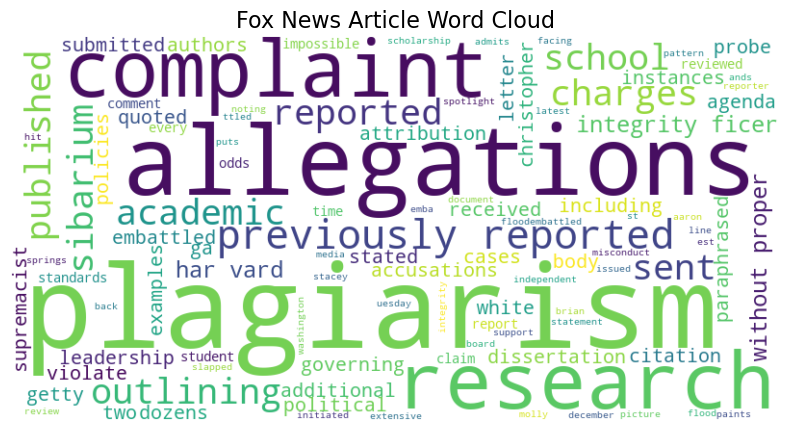

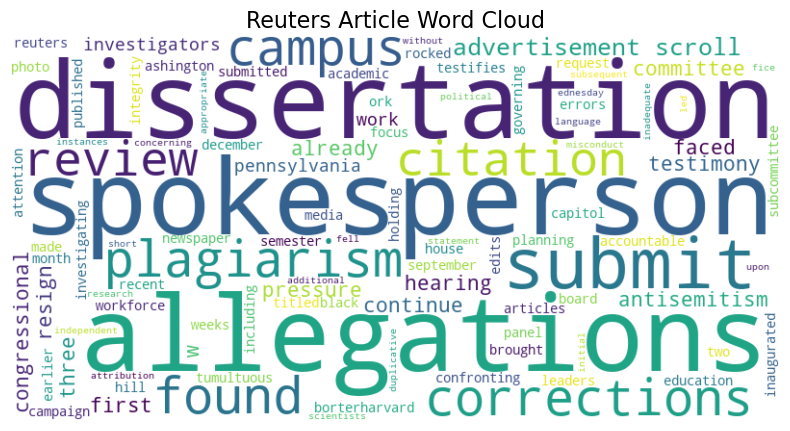

In [72]:
# Define Stopwords (common English words to ignore)
custom_stopwords = stopwords.words('english')
# Add common, non-descriptive words and proper nouns to filter noise
custom_stopwords.extend(['said', 'wrote', 'according', 'gay', 'claudine', 'harvard', 'president', 'university', 'dec', 'new', 'free', 'beacon', 'corporation', 'will', 'was', 'were', 'had', 'her', 'get', 'fox', 'news', 'digital', 'post'])

def create_wordcloud(text, title, stopwords_list):
    """Generates and displays a word cloud."""
    # Tokenize, filter for alpha words, and remove custom stopwords
    tokens = word_tokenize(text)
    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords_list]
    clean_text = " ".join(filtered_tokens)
    
    # Generate and display the word cloud (You will need to run this cell in your notebook to see the plot)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, colormap='viridis').generate(clean_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

create_wordcloud(fox_text, 'Fox News Article Word Cloud', custom_stopwords)
create_wordcloud(reuters_text, 'Reuters Article Word Cloud', custom_stopwords)

# 8.a Word Cloud Insights

Fox News Word Cloud:
Key terms are heavily centered around conflict and seriousness, such as plagiarism, allegations, complaint, and research. These words highlight the accusatory nature of the article and its emphasis on the challenges to the president's credibility and the institution's response. This reinforces the article’s critical tone and aligns with its negatively framed headline.

Reuters Word Cloud:
Dominant words lean toward formal and procedural themes, like dissertation, allegations, spokesperson, citation, and review. The focus here is on administrative handling and policy-level responses, reflecting a more structured and factual tone that matches the article’s neutral, process-oriented reporting style.